# Canon DLSR Scraper

#### Importing the modules

In [133]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from more_itertools import unique_everseen
from pprint import pprint
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from collections import OrderedDict
from datetime import date
import time
import csv
import datetime as dt

In [134]:
#Starting the driver and finding the query element
driver = webdriver.Chrome()
driver.get("https://washingtondc.craigslist.org/nva")
search = driver.find_element_by_id("query")

In [135]:
#Inputing the search keyword
search.send_keys("Canon")
search.send_keys(Keys.ENTER)

In [136]:
#Selecting the photo/video and electronics cateories
driver.find_element_by_css_selector('input.catcheck.selectallcb').click()
driver.find_element_by_css_selector(".catcheck.multi_checkbox[id='cat_pha']").click()
driver.find_element_by_css_selector(".catcheck.multi_checkbox[id='cat_ela']").click()
driver.find_element_by_css_selector("button.searchlink.linklike.changed_input.clickme").click()
#Bundling duplicates, requiring pictures, not including nearby searches
driver.find_element_by_name("bundleDuplicates").click()
driver.find_element_by_name("hasPic").click()
#driver.find_element_by_name("searchNearby").click()

In [137]:
#Inputing the min and max price
minP = driver.find_element_by_name("min_price")
minP.send_keys(500)
time.sleep(1)
maxP = driver.find_element_by_name("max_price")
maxP.send_keys(1500)
maxP.send_keys(Keys.ENTER)

In [138]:
#Prepping for beautiful soup
html = driver.page_source
soup = BeautifulSoup(html, "html.parser")

In [139]:
#Going through all content divs and finding the links
nduplinks = []
duplinks=[] 
#Finding the non duplicated results
nonDups = soup.findAll('li', {'class': 'result-row'})
for item in nonDups:
    nduplinks.append(item.find('a').get('href'))
#Finding the duplicated results
dups = soup.findAll('ul', {'class': 'duplicate-rows'})
for item in dups:
    duplinks.append(item.find('a').get('href'))

In [140]:
#Removing the duplicates, returning the links list
links = [x for x in nduplinks if x not in duplinks]

#Removing duplicate links due to pictures and titles both being the same
links = list(unique_everseen(links))
while "#" in links:
    links.remove("#")

# FOR TEST PURPOSES

In [141]:
links = links[:5]

# -------------------------------------------

In [142]:
#Clicking into the item links
count = 0
dailyitems=[]
itemDict = []
for link in links:
    #Clicking the item link
    link = '"'+link+'"'
    element = driver.find_element_by_xpath('//a[@href=%s]' %link)
    driver.execute_script('arguments[0].click();', element)

    #Getting the item html for beautiful soup
    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")
    #Getting the item price and title
    price = soup.find('span', {'class': 'price'}).get_text()
    title = soup.find('span', {'id': 'titletextonly'}).get_text()
    #Getting the item text
    text = soup.find('section', {'id':'postingbody'}).get_text()
    while "\n" in text:
        text = text.replace("\n", "")
    while "QR Code Link to This Post" in text:
        text = text.replace("QR Code Link to This Post", "")
    itemD = {"Title":title, "Price":price, "Description":text}

    #Making a list of dictionaries
    itemDict.append(itemD)

    #Adding to a list
    dailyitems.append([itemD['Title'], itemD['Price'], itemD['Description']])
    count += 1
    driver.back()

In [143]:
#Outputting the results array item by item
driver.close()
#pprint(dailyitems)
df = pd.DataFrame(itemDict)
current_listings = df
#To Generate the first days csv
#current_listings.to_csv('CanonCurrentListings.csv', index=False, encoding='utf-8')

In [144]:
#Removing the dollar sign in current listings:
if current_listings.Price.dtypes.name != 'int64':
    current_listings['Price'] = pd.to_numeric(current_listings['Price'].str.replace('$', ''))

#Outputting current listings
#current_listings

### Recording the Time the Script Finished Scraping

In [122]:
time_ran = dt.datetime.now()

# Begin Comparisons 

### Read in Past 'current' Listings

In [148]:
#Loading the listings from the day before (Dataframe1)
old_listings = pd.read_csv('CanonCurrentListings.csv')
old_listings

,Description,Price,Title
0,Canon 70-200 F/4 IS L USM lensIn like new cond...,800,Canon 70-200 F/4 IS L USM
1,Canon Macro Lens EF 100mm f/2.8 L IS USM: $700...,700,Canon Macro Lens EF 100mm f/2.8 L IS USM
2,Canon EOS 70D w/ EFS 18-55mm Image Stabilizer ...,500,CANON EOS 70D w/ 18-55mm Lens
3,The lens has been used for only handful times ...,640,Tamron 24-70 F2.8 VC lens for Canon
4,This machine has very low meter. Total count f...,695,Canon imageRUNNER ADVANCED C2225 Color Copier ...


### Start Here for work 6/9/18

In [149]:
#Finding rows in yesterdays listings that are also in todays listing
common = old_listings[old_listings.columns.difference(['Price'])].merge(current_listings, on=['Title', 'Description'])
common

,Description,Title,Price
0,Canon 70-200 F/4 IS L USM lensIn like new cond...,Canon 70-200 F/4 IS L USM,800
1,Canon Macro Lens EF 100mm f/2.8 L IS USM: $700...,Canon Macro Lens EF 100mm f/2.8 L IS USM,700
2,Canon EOS 70D w/ EFS 18-55mm Image Stabilizer ...,CANON EOS 70D w/ 18-55mm Lens,500
3,The lens has been used for only handful times ...,Tamron 24-70 F2.8 VC lens for Canon,640
4,This machine has very low meter. Total count f...,Canon imageRUNNER ADVANCED C2225 Color Copier ...,695


In [163]:
old_listings[['Title', 'Description']] == current_listings[['Title', 'Description']]

,Title,Description
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True


In [19]:
#Finding price change
priceDelta = old_listings.merge(current_listings, on=['Title', 'Description'])
#priceDelta

In [20]:
#Calculating the change
common['Price Delta'] = priceDelta.Price_y.sub(priceDelta.Price_x) + priceDelta['Price Delta']
#change = pd.DataFrame(change)
#change.columns = ['Price Delta']
#common = pd.concat([common, change], axis=1)
#common

In [21]:
#Loading the sold items csv
sold_items = pd.read_csv('SoldItems.csv')

In [22]:
#Removing the $ from Price 
if current_listings.Price.dtypes.name != 'int64':
    sold_items.Price = pd.to_numeric(sold_items.Price.str.replace('$', ''))

#Printing the sold_items dataframe
#sold_items

In [23]:
#Adding items to sold items
sold_items=sold_items.append(old_listings[(~old_listings.Title.isin(common.Title))&(~old_listings.Price.isin(common.Price))])
#sold_items

In [24]:
#Writing to the sold items csv
sold_items.to_csv('SoldItems.csv', index=False, encoding='utf-8')

In [25]:
#current_listings

In [26]:
#Using the same common dataframe from aboce
new_items=(current_listings[(~current_listings.Title.isin(common.Title))])
#Adding the days column to the new items dataframe
new_items = new_items.assign(Days=1)
new_items['Price Delta'] = 0
#new_items = new_items.append(new_items)
#new_items

In [27]:
#Adding days to the listings that were in both dataframes
common['Days'] = [x+1 for x in common['Days']]
#Showing the current listings
current_listings = common
#Adding the new items to the listing if any exist
if len(new_items.Days != 0):
    current_listings=current_listings.append(new_items)
current_listings

,Days,Description,Price,Price Delta,Title
0,13,This is like new Canon T3i in excellent condit...,550,-300,Canon t3i
1,13,This is like new Canon T3i in excellent condit...,550,-300,Canon t3i
2,13,This is like new Canon T3i in excellent condit...,550,-300,Canon t3i
3,7,Leica Canon 35mm f/1.5 RF Rangefinder Lens wit...,895,-55,Canon 35mm f/1.5 RF Leica Mount
4,2,Canon Macro Lens EF 100mm f/2.8 L IS USM: $700...,700,0,Canon Macro Lens EF 100mm f/2.8 L IS USM
0,1,Canon 70-200 F/4 IS L USM lensIn like new cond...,800,0,Canon 70-200 F/4 IS L USM
2,1,Canon EOS 70D w/ EFS 18-55mm Image Stabilizer ...,500,0,CANON EOS 70D w/ 18-55mm Lens
3,1,The lens has been used for only handful times ...,640,0,Tamron 24-70 F2.8 VC lens for Canon
4,1,This machine has very low meter. Total count f...,695,0,Canon imageRUNNER ADVANCED C2225 Color Copier ...
5,1,Up For sale is a Canon EF Zeiss 50mm f/2.0 Mak...,550,0,Zeiss 50mm f/2.0 Makro-Planar ZE Macro Canon E...


In [147]:
#Writing the listings to csv to be used tomorrow
current_listings.to_csv('CanonCurrentListings.csv', index=False, encoding='utf-8')

## Start of Visuals

In [29]:
#Joining descriptions for a wordcloud
s = ''
for item in dailyitems:
    s += item[2]
# print(s)
# wordcloud = WordCloud().generate(s)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# # lower max_font_size
# wordcloud = WordCloud(max_font_size=40).generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

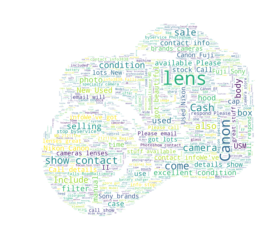

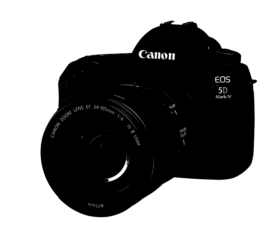

In [30]:
#Making an image in the shape of the camera
# read the mask image
col = Image.open("/Users/mikes/Documents/GetawayDevelopment/camera.jpg")
gray = col.convert('L')
bw = gray.point(lambda x: 0 if x<230 else 255, '1')
bw.save("/Users/mikes/Documents/GetawayDevelopment/camera_mask.jpg")

camera_mask = np.array(Image.open("/Users/mikes/Documents/GetawayDevelopment/camera_mask.jpg"))

wc = WordCloud(background_color="white", max_words=2000, mask=camera_mask)
# generate word cloud
wc.generate(s)

# store to file
wc.to_file("/Users/mikes/Documents/GetawayDevelopment/canon.jpg")

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()

#This plots the grey-scale camera
plt.imshow(camera_mask, cmap='gray', interpolation='bilinear')
plt.axis("off")
plt.show()

In [31]:
df.Price.std()

299.98626636406783

In [32]:
#Accessing the price dataframe
#df.Price = df.Price.str.replace("$", "") !PROBABLY SHOULDN"T BE COMMENTED OUT!!!!
df.Price = pd.to_numeric(df.Price)
df

,Description,Price,Title
0,Canon 70-200 F/4 IS L USM lensIn like new cond...,800,Canon 70-200 F/4 IS L USM
1,Canon Macro Lens EF 100mm f/2.8 L IS USM: $700...,700,Canon Macro Lens EF 100mm f/2.8 L IS USM
2,Canon EOS 70D w/ EFS 18-55mm Image Stabilizer ...,500,CANON EOS 70D w/ 18-55mm Lens
3,The lens has been used for only handful times ...,640,Tamron 24-70 F2.8 VC lens for Canon
4,This machine has very low meter. Total count f...,695,Canon imageRUNNER ADVANCED C2225 Color Copier ...
5,Up For sale is a Canon EF Zeiss 50mm f/2.0 Mak...,550,Zeiss 50mm f/2.0 Makro-Planar ZE Macro Canon E...
6,Up For sale is a Canon EF Zeiss 50mm f/2.0 Mak...,550,Zeiss 50mm f/2.0 Makro-Planar ZE Macro Canon E...
7,Up for sale is a Canon Canon 16-35 F2.8 L II i...,850,"Canon 16-35 F2.8 L II Mint Condition, Flawless"
8,Awesome telephoto lens. Tamron 150-600 G2 (Gen...,980,Tamron 150-600 F5-6.3 G2 Canon Mount
9,"Selling my lens, have a Nikon system, no use f...",900,Canon EF 16-35mm f/2.8L ll USM Zoom Lens for C...


In [33]:
import plotly.plotly as py
from plotly.graph_objs import *

data = [Bar(x=df.Title, y = df.Price)]
py.iplot(data)